## Comparisson of XGBoostRegressor and Linear Regression for predicting Relative CPU Performance Data
### ... and some analytical notes

#### Preface
XGBoost keeps getting more and more recognition as a very powerful algorithm that is able to provide power-ful models. A lot of the parameters and behavior assimilates Linear Regression - except for the obvious fact that it uses gradient boosting via tree regressors -. I aim to understand better the ins-and-outs of the XGBoost algorithm, compare it to the Linear Regression (and Ridge Regression), and apply it to a real world dataset.

#### Feldmesser,Jacob. (1987). Computer Hardware. UCI Machine Learning Repository. https://doi.org/10.24432/C5830D.
 
"Relative CPU Performance Data, described in terms of its cycle time, memory size, etc."

In [63]:
import pandas as pd
from ucimlrepo import fetch_ucirepo 
  
# fetch dataset 
computer_hardware = fetch_ucirepo(id=29) 

# data (as pandas dataframes) 
df = computer_hardware.data.features 
y = computer_hardware.data.targets 


df

VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry           80/8   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 columns]

In [64]:
computer_hardware.variables 

name     role         type demographic  \
0  VendorName  Feature  Categorical        None   
1   ModelName  Feature  Categorical        None   
2        MYCT  Feature      Integer        None   
3        MMIN  Feature      Integer        None   
4        MMAX  Feature      Integer        None   
5        CACH  Feature      Integer        None   
6       CHMIN  Feature      Integer        None   
7       CHMAX  Feature      Integer        None   
8         PRP  Feature      Integer        None   
9         ERP  Feature      Integer        None   

                                         description        units  \
0  (adviser, amdahl,apollo, basf, bti, burroughs,...         None   
1                                many unique symbols         None   
2                                 machine cycle time  nanoseconds   
3                                minimum main memory    kilobytes   
4                                maximum main memory    kilobytes   
5                                       cache memory    kilobytes   
6                                   minimum channels        units   
7                                   maximum channels        units   
8                     published relative performance         None   
9  estimated relative performance from the origin...         None   

  missing_values  
0             no  
1             no  
2             no  
3             no  
4             no  
5             no  
6             no  
7             no  
8             no  
9             no

This dataset was obtained from the UCI dataset repository. Later in this notebook I will be discussing the dataset more in depth, and commenting on Feldmesser's findings. Initially, here is some insight to the data.

In [65]:
df.describe()

MYCT          MMIN          MMAX        CACH       CHMIN  \
count   209.000000    209.000000    209.000000  209.000000  209.000000   
mean    203.822967   2867.980861  11796.153110   25.205742    4.698565   
std     260.262926   3878.742758  11726.564377   40.628722    6.816274   
min      17.000000     64.000000     64.000000    0.000000    0.000000   
25%      50.000000    768.000000   4000.000000    0.000000    1.000000   
50%     110.000000   2000.000000   8000.000000    8.000000    2.000000   
75%     225.000000   4000.000000  16000.000000   32.000000    6.000000   
max    1500.000000  32000.000000  64000.000000  256.000000   52.000000   

            CHMAX          PRP          ERP  
count  209.000000   209.000000   209.000000  
mean    18.267943   105.622010    99.330144  
std     25.997318   160.830733   154.757102  
min      0.000000     6.000000    15.000000  
25%      5.000000    27.000000    28.000000  
50%      8.000000    50.000000    45.000000  
75%     24.000000   113.000000   101.000000  
max    176.000000  1150.000000  1238.000000

Right of the bat we can see that the scale for the features MYCT and MMIN is considerably larger than on other features. This can cause problems when fitting the data to the training set and making predictions on the test set. Some of the reasons include:

- Algorithms that use gradient descent suffer whenever features with higher scale influence the learning process negatively. This can lead to the model focusing mainly on features with a larger scale.

- Similarly, algorithms that use gradient descent may suffer from larger gradient steps and a possible slower convergence when dealing with large numbers.

- Regulatization (which we plan to implement) might affect different features disproportionately and unfairly based on their scale. This can lead to poor model preformance.

- For interpretability reasons, smaller numbers are easier to deal with, and insights on data are easier to derive when dealing with normalized data.

For this reason I will be normalizing the data. That being said, at first I want to train and test the algorithms with these default values, to understand the differences on how these algorithms react to features with larger scales.

In [66]:
df.info

<bound method DataFrame.info of     VendorName      ModelName  MYCT  MMIN   MMAX  CACH  CHMIN  CHMAX  PRP  ERP
0      adviser          32/60   125   256   6000   256     16    128  198  199
1       amdahl         470v/7    29  8000  32000    32      8     32  269  253
2       amdahl        470v/7a    29  8000  32000    32      8     32  220  253
3       amdahl        470v/7b    29  8000  32000    32      8     32  172  253
4       amdahl        470v/7c    29  8000  16000    32      8     16  132  132
..         ...            ...   ...   ...    ...   ...    ...    ...  ...  ...
204     sperry           80/8   124  1000   8000     0      1      8   42   37
205     sperry  90/80-model-3    98  1000   8000    32      2      8   46   50
206     sratus             32   125  2000   8000     0      2     14   52   41
207       wang         vs-100   480   512   8000    32      0      0   67   47
208       wang          vs-90   480  1000   4000     0      0      0   45   25

[209 rows x 10 colu

#### Nessesary Libraries:

In [67]:
import numpy as np
import xgboost as xgb


from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from scipy.stats import uniform, randint

In [68]:
y=df['PRP']

In [69]:
X = df.drop(columns=['VendorName','ModelName','ERP','PRP'], axis=1)

In [70]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

A simple 70%/30% split is good for now. Later on we will perform K-fold crossvalidation

In [71]:
seed = 7
test_size = 0.3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

At first I will be using the following hyperparameters. Later on I will be performing hypterparameter optimization.

In [72]:
model = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
             max_depth = 5, alpha = 10, n_estimators = 10)

In [73]:
model.fit(X_train, y_train)

XGBRegressor(alpha=10, base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.3, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=10, n_jobs=None,
             num_parallel_tree=None, ...)

I will be using Root Mean Squared Error for this analysis at first. Later on I might explore with different error metrics. 

In [74]:
import numpy as np

train_predictions = model.predict(X_train)
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))

test_predictions = model.predict(X_test)
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

print("Train set RMSE: %f" % (train_rmse))
print("Test set RMSE: %f" % (test_rmse))

Train set RMSE: 90.293381
Test set RMSE: 135.548507


In [75]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RandomizedSearchCV

In [76]:
# Cross-Validation for XGBoost
scores = cross_val_score(model, X, y, cv=5, scoring='neg_mean_squared_error')
print("XGBoost Cross-validated RMSE: ", np.sqrt(-scores.mean()))

XGBoost Cross-validated RMSE:  128.70723779103722


In [77]:
# Hyperparameter grid
param_dist = {
    'n_estimators': randint(50, 200),
    'learning_rate': uniform(0.01, 0.2),
    'max_depth': randint(3, 10),
    'colsample_bytree': uniform(0.3, 0.7),
    'alpha': uniform(0, 10)
}

# Randomized Search
rand_search = RandomizedSearchCV(model, param_distributions=param_dist, n_iter=25, scoring='neg_mean_squared_error', cv=3, verbose=1, n_jobs=-1, random_state=42)
rand_search.fit(X_train, y_train)

# Best Parameters and RMSE
print("Best Parameters: ", rand_search.best_params_)
best_rmse = np.sqrt(-rand_search.best_score_)
print("Best RMSE: ", best_rmse)


Fitting 3 folds for each of 25 candidates, totalling 75 fits
Best Parameters:  {'alpha': 8.445338486781514, 'colsample_bytree': 0.8231240770961665, 'learning_rate': 0.11793842647781595, 'max_depth': 4, 'n_estimators': 173}
Best RMSE:  82.88814627817864


In [78]:
from sklearn.linear_model import LinearRegression

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

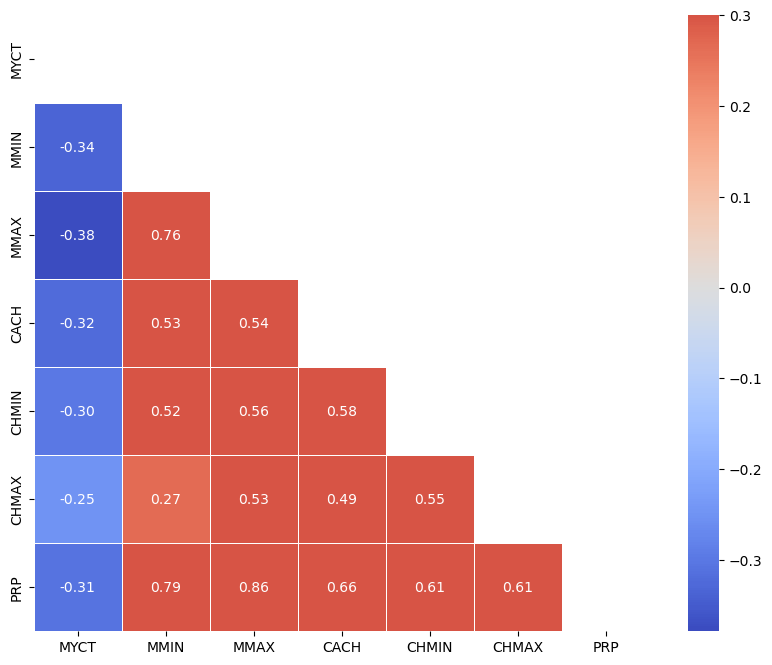

In [82]:
# Compute the correlation matrix
corr_matrix = df.drop(columns=['VendorName','ModelName','ERP']).corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Set up the matplotlib figure
plt.figure(figsize=(10, 8))

# Draw the heatmap with the mask
sns.heatmap(corr_matrix, mask=mask, cmap='coolwarm', vmax=.3, center=0, square=True, linewidths=.5, annot=True, fmt=".2f")

# Show plot
plt.show()


The features MMIN and MMAX show a strong positive correlation with PRP, which might suggest that these features are good predictors of the CPU performance (PRP).
The feature MYCT has a negative correlation with PRP, indicating that higher machine cycle times may be associated with lower performance.
MMAX and MMIN are highly correlated with each other, which is expected as they are related aspects of memory size.